# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.352190,False,-0.927897
1,0.667495,False,1.297431
2,0.204493,True,6.447053
3,-0.656047,False,-0.185633
4,0.031887,True,6.451022
...,...,...,...
995,-1.705269,False,-0.604135
996,-0.407632,True,5.384678
997,0.875107,False,1.178020
998,-0.376134,False,-0.571839


<Axes: xlabel='v0'>

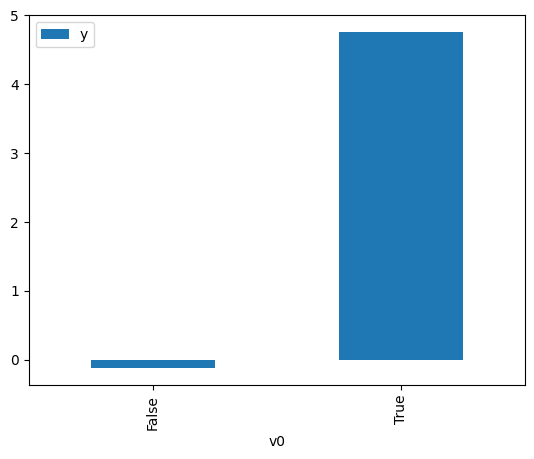

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

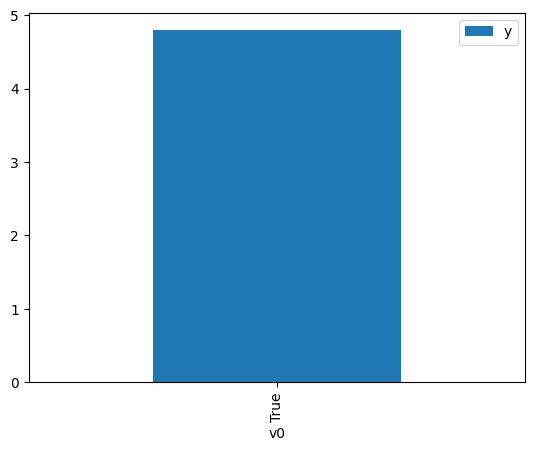

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.375244,False,1.104099,0.363827,2.748559
1,-0.388845,False,-1.021258,0.577917,1.730353
2,-0.785183,False,-0.998818,0.682886,1.464372
3,-0.598990,False,-1.877200,0.635140,1.574457
4,0.210882,False,-0.394459,0.408300,2.449180
...,...,...,...,...,...
995,1.369478,False,-0.289556,0.155150,6.445372
996,0.341684,False,-1.154411,0.372748,2.682781
997,0.477866,False,2.905489,0.337145,2.966084
998,-0.376134,False,-0.571839,0.574370,1.741038


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.902570,True,7.053382,0.761568,1.313081
1,-0.136797,True,3.454109,0.493439,2.026594
2,-1.995830,True,4.216734,0.104302,9.587500
3,0.470499,True,4.162208,0.660972,1.512924
4,0.397903,True,5.426082,0.642144,1.557283
...,...,...,...,...,...
995,-1.620620,True,5.100763,0.151664,6.593506
996,0.730562,True,4.747494,0.724075,1.381073
997,-1.418336,True,5.086035,0.183849,5.439250
998,0.375236,True,5.092037,0.636171,1.571905


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.927
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                              6375.
Date:                Thu, 13 Jul 2023   Prob (F-statistic):                        0.00
Time:                        22:05:46   Log-Likelihood:                         -1406.7
No. Observations:                1000   AIC:                                      2817.
Df Residuals:                     998   BIC:                                      2827.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4650      0.030     15.300      0.000       0.405       0.525
x2             4.9772      0.046    107.895      0.000       4.887       5.068
==============================================================================
Omnibus:                        4.629   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.099   Jarque-Bera (JB):                4.537
Skew:                           0.138   Prob(JB):                        0.103
Kurtosis:                       3.181   Cond. No.                         1.57
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""